In [1]:
# !pip install torch==2.2.1
# !pip install torchvision==0.17.1
# !pip install pillow==10.2.0
# !pip install scipy==1.12.0
# !pip install numpy==1.26.3
# !pip install scikit-learn==1.4.1.post1
!pip install higher==0.2.1
# !pip install tqdm==4.51.0

In [2]:
import pandas as pd
import numpy as np
import torch
import os
import shutil
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
import higher
from tqdm import tqdm 
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader, Subset
from transformers import ConvNextForImageClassification
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torchinfo import summary
from PIL import Image


In [3]:
class MultiPartDataset(Dataset):
    def __init__(self, path_to_folders, label_csv, transform):
        self.meta_data = pd.read_csv(label_csv)
        self.path_to_folders = path_to_folders
        self.data = []
        
        dx, self.class_labels = pd.factorize(self.meta_data['dx'], sort=True)
        for path in self.path_to_folders:
            files = os.listdir(path)
            for file in sorted(files):
                idx = self.meta_data['image_id'] == file.split('.')[0]
                self.data.append((path, file, int(dx[idx][0])))
    
        self.data = np.array(self.data)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data[idx][0], self.data[idx][1])
        image = Image.open(img_name)
        label = self.data[idx][2]

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(int(label))
    
    def split_train_test_val(self, test_samples_per_class=10, val_samples_per_class=5):
        indices = np.arange(len(self))
        train_idx, test_idx, val_idx = [], [], []

        for i, c in enumerate(self.class_labels):
            class_indices = np.where(self.data[:, 2] == str(i))[0]
            
            if len(class_indices) < test_samples_per_class + val_samples_per_class:
                print(len(class_indices), test_samples_per_class, val_samples_per_class, class_indices)
                raise ValueError(f"Not enough samples for class {c} to fulfill test and validation requirements.")
            
            chosen_indices = np.random.choice(class_indices[:-test_samples_per_class], val_samples_per_class, replace=False)
            test_idx.extend(class_indices[-test_samples_per_class:])
            val_idx.extend(chosen_indices)

        train_idx = [idx for idx in indices if idx not in test_idx and idx not in val_idx]

        train_set = Subset(self, train_idx)
        test_set = Subset(self, test_idx)
        val_set = Subset(self, val_idx)

        return train_set, test_set, val_set, train_idx, test_idx, val_idx


In [4]:
folders = ["/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1", "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"]
meta_csv_file_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = MultiPartDataset(folders, meta_csv_file_path, transform)

In [5]:
def plot_class_distribution(indices, title):
    labels = [dataset.data[i][2] for i in indices]
    class_counts = np.bincount(labels, minlength=len(dataset.class_labels))
    plt.bar(range(len(class_counts)), class_counts, tick_label=list(dataset.class_labels))
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

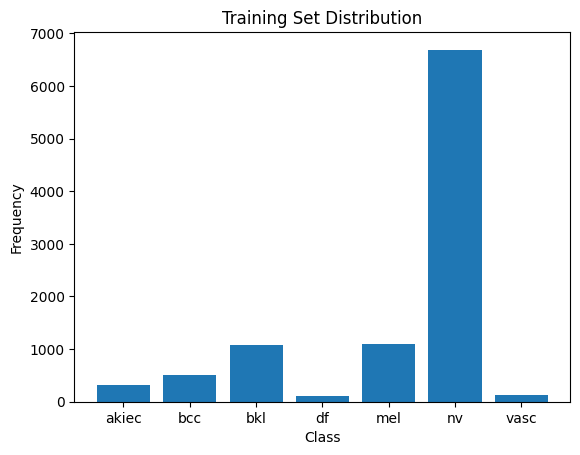

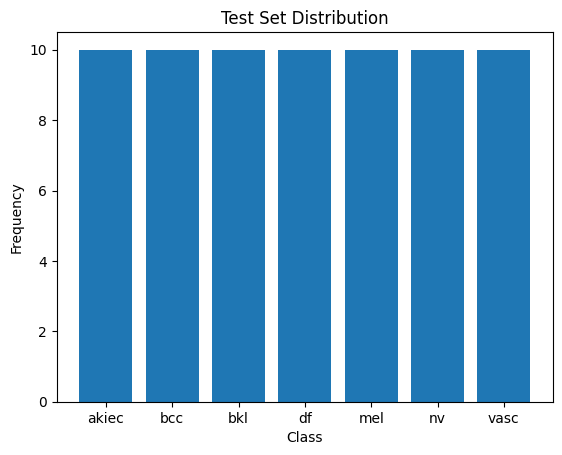

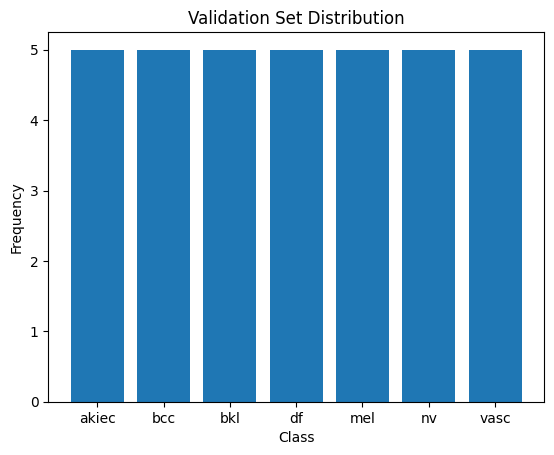

In [6]:
trainset, testset, valset, train_idx, test_idx, val_idx = dataset.split_train_test_val()

plot_class_distribution(train_idx, 'Training Set Distribution')
plot_class_distribution(test_idx, 'Test Set Distribution')
plot_class_distribution(val_idx, 'Validation Set Distribution')

In [7]:
print(f"Train set contains : {len(trainset)}\n")
print(f"Test set contains : {len(testset)}\n")
print(f"Val set contains : {len(valset)}\n")

Train set contains : 9910

Test set contains : 70

Val set contains : 35



In [8]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
testloader = DataLoader(testset, batch_size=8)
valloader = DataLoader(valset, batch_size=32, shuffle=True)

In [9]:
model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
name = 'ResNet50'
save_path = '/kaggle/working'

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s] 


In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
loss_fn_mean_red = nn.CrossEntropyLoss(reduction="mean")
loss_fn_no_red = nn.CrossEntropyLoss(reduction="none")
loss_fn = nn.CrossEntropyLoss()

In [11]:
def compute_accuracy(model, test_loader, loss_fn):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    correct, total = 0, 0
    loss_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss_total += torch.sum(loss) / 8
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total * 100, loss_total / len(test_loader)

In [14]:
def train(model, train_loader, val_loader, test_loader, optimizer, loss_fn, name, save_path, epochs=10, checkpoint = 1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    model.train()
    for epoch in range(epochs):
        loss_sum = 0
        train_progress = tqdm(train_loader, desc="Training", leave=False)
        for img, labels in train_progress:
            img, labels = img.to(device), labels.to(device)
            batch_size = img.shape[0]
            epsilon = torch.zeros(batch_size, requires_grad=True, device=device)        
            optimizer.zero_grad()

            with higher.innerloop_ctx(model, optimizer) as (meta_model, meta_opt):

                meta_outputs = meta_model(img)
                loss_fn.reduction = 'none'
                meta_loss = loss_fn(meta_outputs, labels)
                #print("meta loss", meta_loss)
                weighted_meta_loss = torch.sum(epsilon * meta_loss)
                meta_opt.step(weighted_meta_loss)

                # Compute Valdiation loss using the intermidiate model
                # TODO(Parth): next(iter(val_loader)) will always give the first element of val_loader
                #              This only works in case of CIFAR-10 because we just have one mini-batch in val_loader
                val_img, val_labels = next(iter(val_loader))
                val_img, val_labels = val_img.to(device), val_labels.to(device)
                val_outputs = meta_model(val_img)
                loss_fn.reduction = 'mean'
                val_loss = loss_fn(val_outputs, val_labels)
                #print("val loss", val_loss)
                eps_grads = torch.autograd.grad(val_loss, epsilon)[0].detach()
            weights = torch.clamp(-eps_grads, min=0)
            weights_norm = torch.sum(weights)
            weights_norm = weights_norm if weights_norm != 0 else 1
            weights = weights / weights_norm
            outputs = model(img)
            #print("weights", weights)
            loss_fn.reduction = 'none'
            loss = loss_fn(outputs, labels)
            #print("loss", loss)
            weighted_loss = torch.sum(weights * loss)
            loss_sum += torch.sum(loss) / 16
            #print("weighted_loss", weighted_loss)
            weighted_loss.backward()

            optimizer.step()
            
        print(f"Epoch: {epoch} | Loss: {loss_sum/len(train_loader)}")

        if epoch % checkpoint == 0:
                loss_fn.reduction = 'none'
                acc, loss_avg = compute_accuracy(model, test_loader, loss_fn)
                print(f"Accuracy: {acc:.2f}%, Loss: {loss_avg:.2f}")
                if False:
                    save_path_1 = os.path.join(save_path, f"{name}_checkpoint_{epoch // checkpoint}.pth")
                    print(f"Saving model checkpoint at {save_path_1}")
                    torch.save(model.state_dict(), save_path_1)

In [ ]:
train(model, trainloader, valloader, testloader, optimizer, loss_fn, name, save_path)

cuda


Training:   5%|▌         | 32/620 [00:54<17:00,  1.74s/it]

In [ ]:
class_labels = list(dataset.class_labels)

class TestDataset(Dataset):
    def __init__(self, path_to_img_folder, path_to_csv, transform):
        self.labels = pd.read_csv(path_to_csv)
        self.path_to_img_folder = path_to_img_folder
        self.data = []
        
        i = 0
        for file in sorted(os.listdir(self.path_to_img_folder)):
            if file[-4:] == ".jpg":
                idx = self.labels['image'] == file.split('.')[0]
                class_name = self.labels[idx].eq(1.0).idxmax(axis=1).values[0].lower()
                self.data.append((file, class_labels.index(class_name)))
    
        self.data = np.array(self.data)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.path_to_img_folder, self.data[idx][0])
        image = Image.open(img_name)
        label = self.data[idx][1]

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(int(label))

In [ ]:
path_to_csv = "/kaggle/input/isic-2018-task-3/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"
path_to_test_img = "/kaggle/input/isic-2018-task-3/ISIC2018_Task3_Test_Input/ISIC2018_Task3_Test_Input"
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_dataset = TestDataset(path_to_test_img, path_to_csv, transform)
test_loader = DataLoader(test_dataset, batch_size=8)


In [ ]:
compute_accuracy(model, test_loader, loss_fn)